# Physical Risk Propagation Model (EU-27 SAM)

This notebook:
1. Loads the latest EU-27 SAM (long format)
2. Extracts IO-style model inputs (Z, FD, X, A, globsec_of, node_labels)
3. Runs scenario simulations (supply and/or demand shocks)
4. Produces summary metrics and basic visualizations


In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

import numpy as np
import pandas as pd

from data_io.eurostat_sam import load_sam_latest_year, extract_model_inputs_from_sam
from io_climate.model import IOClimateModel


## 1) Load SAM and build model inputs


In [2]:
sam_df, latest_year = load_sam_latest_year(spark)
print("SAM year:", latest_year)
print("Rows:", sam_df.count())

Z, FD, X, A, globsec_of, node_labels = extract_model_inputs_from_sam(sam_df)

n = len(node_labels)
print("n nodes:", n)
print("Z shape:", Z.shape, "A shape:", A.shape)


SAM year: 2022
Rows: 2040159
n nodes: 1695
Z shape: (1695, 1695) A shape: (1695, 1695)


In [3]:
globsec_of.shape

(1695,)

In [4]:
assert Z.shape == (n, n)
assert A.shape == (n, n)
assert FD.shape == (n,)
assert X.shape == (n,)
assert len(globsec_of) == n

# Non-negativity (expected for SAM blocks)
print("Z min:", Z.min(), "FD min:", FD.min(), "X min:", X.min(), "A min:", A.min())


Z min: 0.0 FD min: -0.040412221578703625 X min: 1.2000000000907844 A min: 0.0


## 2) Instantiate the model

Important: `model.run(...)` mutates the model state (Z, A, L, X).  
So we store baseline values explicitly before running scenarios.


In [5]:
model = IOClimateModel(
    Z=Z,
    FD=FD,
    X=X,
    globsec_of=globsec_of,
    A=A,
    node_labels=node_labels,
)

X_baseline = X.copy()
FD_baseline = FD.copy()
Z_baseline = Z.copy()

print("Model created.")
print("Baseline total output:", float(X_baseline.sum()))
print("Baseline total final demand:", float(FD_baseline.sum()))


Model created.
Baseline total output: 28772842.248214405
Baseline total final demand: 14831340.773248244


## 3) Define a scenario and run

Example:
- Supply shock: -5% capacity
- Country: IT
- Sectors: choose one or more NACE blocks (e.g., P_C10-12)


In [6]:
scenario = dict(
    country_codes=["IT"],
    sector_codes=["P_C10-12"],
    supply_shock_pct=5.0,
    demand_shock_pct=0.0,
    gamma=0.2,
    max_iter=50,
    tol=1e-6,
    return_history=True,
)

results = model.run(**scenario)

print("Converged:", results["converged"])
print("Iterations:", results["iterations"])
print("Demand gap last:", results["demand_gap_last"])
print("Output gap last:", results["output_gap_last"])


Converged: False
Iterations: 50
Demand gap last: 0.997214391830882
Output gap last: 0.9972143872073317


## 4) Extract results and compute impact metrics


In [7]:
X_final = results["X_supply_final"]
FD_post = results["FD_post"]
FD_implied = results["FD_implied_final"]

df_nodes = pd.DataFrame({
    "node": node_labels,
    "country": [lbl.split("::")[0] for lbl in node_labels],
    "sector": [lbl.split("::")[1] for lbl in node_labels],
    "X_baseline": X_baseline,
    "X_final": X_final,
})

df_nodes["X_change_abs"] = df_nodes["X_final"] - df_nodes["X_baseline"]
df_nodes["X_change_pct"] = np.where(
    df_nodes["X_baseline"] > 0,
    100.0 * df_nodes["X_change_abs"] / df_nodes["X_baseline"],
    np.nan
)

df_nodes.sort_values("X_change_pct").head(10)


,node,country,sector,X_baseline,X_final,X_change_abs,X_change_pct
1251,MT::P_S94,MT,P_S94,17.859000,-0.005246,-17.864246,-100.029377
1494,RO::P_N78,RO,P_N78,1184.313000,-0.040412,-1184.353412,-100.003412
734,FR::P_K66,FR,P_K66,60537.288005,-0.022915,-60537.310920,-100.000038
1040,LT::P_H52,LT,P_H52,2904.539000,0.000000,-2904.539000,-100.000000
365,DE::P_N79,DE,P_N79,13546.888000,0.000000,-13546.888000,-100.000000
751,FR::P_S94,FR,P_S94,6713.310001,0.000000,-6713.310001,-100.000000
99,BE::P_J58,BE,P_J58,2989.146000,0.000000,-2989.146000,-100.000000
668,FI::P_J62_63,FI,P_J62_63,11940.500001,0.000000,-11940.500001,-100.000000
933,IE::P_N80-82,IE,P_N80-82,8142.387001,0.000000,-8142.387001,-100.000000
511,EL::P_C18,EL,P_C18,697.184000,0.000000,-697.184000,-100.000000


In [8]:
df_country = df_nodes.groupby("country", as_index=False)[["X_baseline","X_final","X_change_abs"]].sum()
df_country["X_change_pct"] = 100.0 * df_country["X_change_abs"] / df_country["X_baseline"]
df_country.sort_values("X_change_pct").head(10)


,country,X_baseline,X_final,X_change_abs,X_change_pct
23,RO,5.245929e+05,-0.040412,-5.245930e+05,-100.000008
2,BG,1.683506e+05,0.000000,-1.683506e+05,-100.000000
18,LV,6.714581e+04,0.000000,-6.714581e+04,-100.000000
10,FI,4.685664e+05,0.000000,-4.685664e+05,-100.000000
14,IE,6.134451e+05,7.888424,-6.134372e+05,-99.998714
21,PL,1.310212e+06,48.655000,-1.310163e+06,-99.996286
13,HU,3.199112e+05,22.745000,-3.198885e+05,-99.992890
12,HR,1.132184e+05,16.436000,-1.132020e+05,-99.985483
0,AT,8.110387e+05,144.950000,-8.108937e+05,-99.982128
26,SK,2.394384e+05,49.080000,-2.393894e+05,-99.979502


In [9]:
df_sector = df_nodes.groupby("sector", as_index=False)[["X_baseline","X_final","X_change_abs"]].sum()
df_sector["X_change_pct"] = 100.0 * df_sector["X_change_abs"] / df_sector["X_baseline"]
df_sector.sort_values("X_change_pct").head(10)


,sector,X_baseline,X_final,X_change_abs,X_change_pct
50,P_N78,2.028068e+05,-0.040412,-2.028068e+05,-100.000020
42,P_K66,2.634607e+05,-0.022915,-2.634607e+05,-100.000009
59,P_S94,8.179933e+04,-0.005246,-8.179933e+04,-100.000006
54,P_P85,8.283354e+05,0.000000,-8.283354e+05,-100.000000
3,P_B,1.200065e+05,0.000000,-1.200065e+05,-100.000000
33,P_H52,6.848223e+05,0.000000,-6.848223e+05,-100.000000
43,P_L,1.951634e+06,0.000000,-1.951634e+06,-100.000000
41,P_K65,3.264681e+05,0.000000,-3.264681e+05,-100.000000
40,P_K64,7.225892e+05,0.000000,-7.225892e+05,-100.000000
0,P_A01,5.331892e+05,0.000000,-5.331892e+05,-100.000000


## 5) Visualizations (with safe fallback if matplotlib is missing)


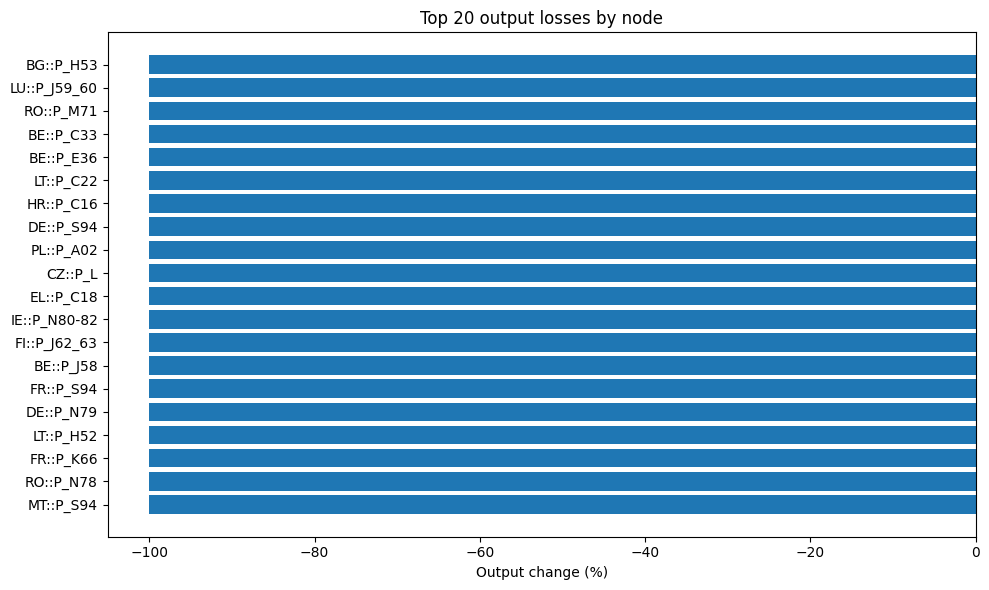

In [10]:
top = df_nodes.sort_values("X_change_pct").head(20)

try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.barh(top["node"], top["X_change_pct"])
    plt.xlabel("Output change (%)")
    plt.title("Top 20 output losses by node")
    plt.tight_layout()
    plt.show()

except ModuleNotFoundError:
    print("matplotlib not installed. Showing top 20 losses as a table instead.")
    display(top[["node","X_change_pct","X_baseline","X_final"]])


## 6) Demand consistency diagnostics


In [11]:
df_demand = pd.DataFrame({
    "node": node_labels,
    "FD_post": FD_post,
    "FD_implied": FD_implied,
    "delta": FD_implied - FD_post
})
df_demand["abs_delta"] = df_demand["delta"].abs()

print("Total FD_post:", float(df_demand["FD_post"].sum()))
print("Total FD_implied:", float(df_demand["FD_implied"].sum()))
df_demand.sort_values("abs_delta", ascending=False).head(10)


Total FD_post: 14831340.773248244
Total FD_implied: 41314.30439897144


,node,FD_post,FD_implied,delta,abs_delta
367,DE::P_O84,368529.547571,0.0,-368529.547571,368529.547571
735,FR::P_L,300307.979983,0.0,-300307.979983,300307.979983
369,DE::P_Q86,291918.622036,0.0,-291918.622036,291918.622036
340,DE::P_F,251361.102051,0.0,-251361.102051,251361.102051
745,FR::P_O84,251014.884836,0.0,-251014.884836,251014.884836
718,FR::P_F,236414.826551,0.0,-236414.826551,236414.826551
343,DE::P_G47,207668.958680,0.0,-207668.958680,207668.958680
333,DE::P_C29,203720.129984,0.0,-203720.129984,203720.129984
747,FR::P_Q86,203369.664763,0.0,-203369.664763,203369.664763
368,DE::P_P85,201976.016720,0.0,-201976.016720,201976.016720
